$$\huge \text {Computer Assignment 3 - Decision Tree & Rndom Forest}$$

$$\large \text {In this project, we want to predict the type of movie (Movie or TV Show) using Decision Trees and Random Forests.}$$

***
# Phase Zero: Analysing the dataset

## Importing libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import graphviz
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


## Reading the csv file

In [6]:
df = pd.read_csv("dataset.csv")
df.head()

,type,title,cast,country,release_year,listed_in,description
0,Movie,Dick Johnson Is Dead,NaN,United States,2020,Documentaries,"As her father nears the end of his life, filmm..."
1,TV Show,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,TV Show,Ganglands,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,TV Show,Jailbirds New Orleans,NaN,NaN,2021,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,TV Show,Kota Factory,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Info and Describe methods from pandas

In [7]:
print(df.describe())
print('\n----------------------------------------------------------------------\n')
print(df.info())

       release_year
count  11059.000000
mean    2014.209603
std        8.959517
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000

----------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059 entries, 0 to 11058
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          11059 non-null  object
 1   title         11059 non-null  object
 2   cast          9694 non-null   object
 3   country       8364 non-null   object
 4   release_year  11059 non-null  int64 
 5   listed_in     11059 non-null  object
 6   description   11059 non-null  object
dtypes: int64(1), object(6)
memory usage: 604.9+ KB
None


## Percentage of missing values

In [8]:
print(100 * df.isna().sum()/len(df))

type             0.000000
title            0.000000
cast            12.342888
country         24.369292
release_year     0.000000
listed_in        0.000000
description      0.000000
dtype: float64


***
# Phase One: Preprocessing

## Handling missing values

### Dropping rows with missing values
We don't have 24 percent of the data that relates to the **country** attribute and 12 percent of the data that relates to the **cast** attribute, so with this method, we lose at least 24 percent of our data; which seems not good.

### Replacing with mean/median/mode
In this method we replace the missing values with mean, median, or mode. Because here the columns that have missing values are categorical, we replace missing values with mode.

In [9]:
df['country'].fillna(df['country'].mode()[0], inplace=True)
df['cast'].fillna(df['cast'].mode()[0], inplace=True)

## Normalization or Standardization
**Normalization** or **Standardization** are techniques to standardize the independent features present in the data in a fixed range.

### Normalization
Normalization rescales the values into a range of $[0,1]$.<br><br>\begin{equation*}
\large X = \frac {X - X_{min}}{X - X_{max}}
\end{equation*}


### Standardization
Standardization rescales data to have a mean of 0 and standard deviation of 1.<br><br>\begin{equation*}
\large X = \frac {X - \mu}{\sigma}
\end{equation*}


## Handling categorical attributes

### Label Encoding
With this method, we simply replace the categorical value with a numeric value between zero and the number of classes minus one.
#### Disadvantage
Numbers hold relationships. For instance, four is twice two, and, when converting categories into numbers directly, these relationships are created despite not existing between the original categories.This is especially an issue for algorithms, such as K-Means, where a distance measure is calculated when running the model.

In [10]:
def categorical_to_numerical(data, columns, method='Label_Encoding'):
    if method == 'Label_Encoding':
        le = preprocessing.LabelEncoder()
        for col in columns: 
            le.fit(data[col])
            data[col] = le.transform(data[col])

In [11]:
categorical_to_numerical(df, ['country', 'type'])

Here we construct another dataframe, which its categorical set features will directly convert to numerical.

In [12]:
df_2 = copy.deepcopy(df)
categorical_to_numerical(df_2, ['cast', 'title', 'listed_in', 'description'])

### One-Hot Encoding
In this method, a one-hot encoding can be applied to the ordinal representation. This is where the integer encoded variable is removed and one new binary variable is added for each unique integer value in the variable.
#### Disadvantage
The high number of features can cause inefficiency.

### Because we want to perform decision tree algorithm, we don't need to perform One-Hot Encoding. Also we have many features, which means One-Hot Encoding is not good.

## Handling set attributes
First we identify which genres we have in this dataset and we add new columns based on those generes. Then we go through each movie and check the genres which that movie contains.  

In [13]:
def separating_set_attributes(data, columns):
    for col in columns:
        attributes_set = set()
        for features in data[col]:
            for feature in features.split(', '):
                attributes_set.add(feature)

        for feature in attributes_set:
            data[feature] = 0

        for index, row in data.iterrows():
            for feature in row[col].split(', '):
                data.at[index, feature] = 1    

In [14]:
separating_set_attributes(df, ['listed_in'])

## Extracting features from text
Because we have text features, we can split the text into its words and count the number of most frequented words in the whole dataset. Then we can iterate over the rows of our dataset and determine which of those most frequented words appear in this row.

### Count Vectorizer
**Count Vectorizer** is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

In [15]:
def get_top_n_words(feature, n, stop_words=None, token_pattern=r'(?u)\b\w\w+\b'):
    vectorizer = CountVectorizer(stop_words=stop_words, token_pattern=token_pattern)
    X = vectorizer.fit_transform(feature)
    sum_words = X.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
cast_features = get_top_n_words(df['cast'], 10, token_pattern='(?u)\w+[\s\`]\w+')
df['description+title'] = df['title'] + ' ' + df['description']
desc_and_title_features = get_top_n_words(df['description+title'], 50, stop_words=stopwords.words('english'))

In [17]:
def set_text_features(data, features, columns):
    text_features = []
    for feature in features:
        text_features.append(feature[0])
        data[feature[0]] = 0
    for col in columns:
        if col == 'cast':
            vectorizer = CountVectorizer(token_pattern='(?u)\w+[\s\`]\w+')
        else:
            vectorizer = CountVectorizer()
        analyze = vectorizer.build_analyzer()
        for index, row in data.iterrows():
            count = dict(Counter(analyze(row[col])))
            for k, v in count.items():
                if k in text_features:
                    data.at[index, k] = v

In [18]:
set_text_features(df, desc_and_title_features+cast_features, ['description+title', 'cast'])

### TF-IDF
**TF-IDF** is an abbreviation for Term Frequency Inverse Document Frequency. 
TF-IDF is a measure of originality of a word by comparing the number of times a word appears in a doc with the number of docs the word appears in. <br> See this [link](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a) for more information.<br>

### What is the effect of extracting more features?
Using more features is not good always. If we consider each feature in our decision tree, our model would overfit. But extracting good features(with better information gain) can lead us to have better classification.

## Investigate the relationships between features

### Information Gain
Information Gain, or IG for short, measures the reduction in entropy or surprise by splitting a dataset according to a given value of a random variable. A larger information gain suggests a lower entropy group or groups of samples, and hence less surprise. Entropy quantifies how much information there is in a random variable, or more specifically its probability distribution.

In [19]:
X = copy.deepcopy(df.drop(columns=['type', 'title', 'description', 'cast', 'listed_in', 'description+title']))
y = df['type']
info_gain = mutual_info_classif(X, y)
info_gain = np.array(info_gain)

#### Plotting each feature with its Information Gain

In [20]:
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_axes([0,0,25,10])
ax.bar(X.columns, info_gain, label='Information Gain')
plt.xticks(fontsize=100, rotation=90)
plt.yticks(fontsize=150)
plt.legend()
plt.xlabel('Attribute', fontsize=250)
plt.ylabel('Information Gain', fontsize=200)
plt.show()

#### Plotting best Information Gains

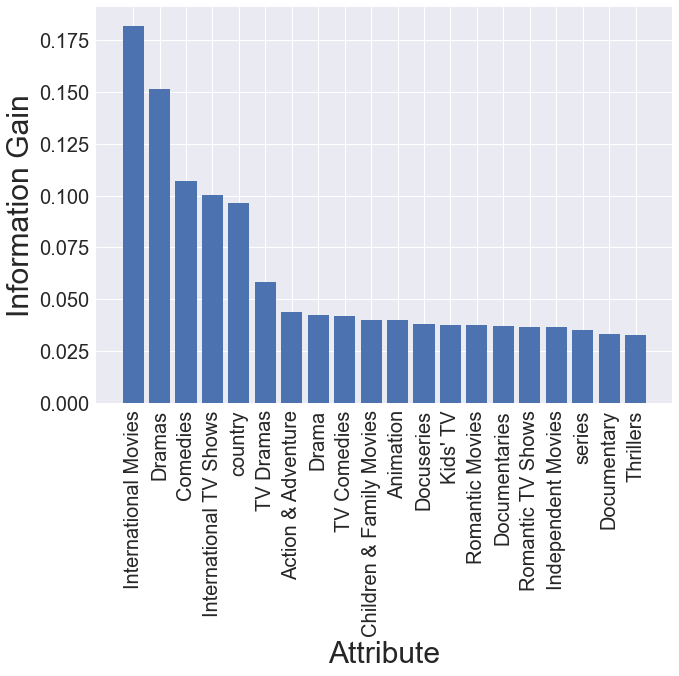

In [21]:
sorted_info_gain = info_gain.argsort()[:][::-1]
cols = []
best_info_gain = []
for i in range(20):
    cols.append(X.columns[sorted_info_gain[i]])
    best_info_gain.append(info_gain[sorted_info_gain[i]])
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cols, best_info_gain)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.xlabel('Attribute', fontsize=30)
plt.ylabel('Information Gain', fontsize=30)
plt.show()

### What this plot shows?
Information gain helps us to determine the order of attributes in the nodes of a decision tree. The main node is referred to as the parent node, whereas sub-nodes are known as child nodes.

***
# Phase Two: Goal prediction and model optimization

## split the dataset into train and test data
**train_test_split** is a function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data. Here we take 80% of the whole data for training the model and the rest for the testing. **random_state** controls the shuffling applied to the data before applying the split.<br> here are two competing concerns: with less training data, our parameter estimates have greater variance. With less testing data, our performance statistic will have greater variance. We should be concerned with dividing data such that neither variance is too high, which is more to do with the absolute number of instances in each category rather than the percentage.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Train

In [23]:
clf = tree.DecisionTreeClassifier(max_depth=11, min_samples_split=2)
clf = clf.fit(X_train,y_train)

## Test

In [24]:
y_pred = clf.predict(X_test)

## Accuracy

In [25]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9990958408679927


## Confusion matrix
**Confusion matrix** is a performance measurement for machine learning classification problem where output can be two or more classes. Here it is a table with 4 different combinations of predicted and actual values.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


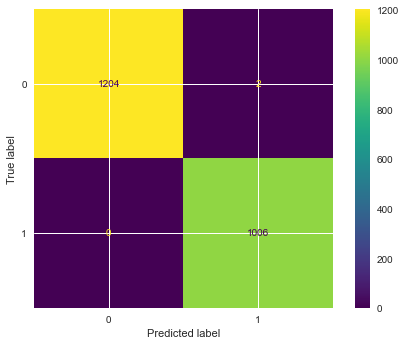

In [26]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

## max_depth and min_samples_split
- **max_depth:** The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **min_samples_split:** The minimum number of samples required to split an internal node.(default: 2)

## Plotting the tree

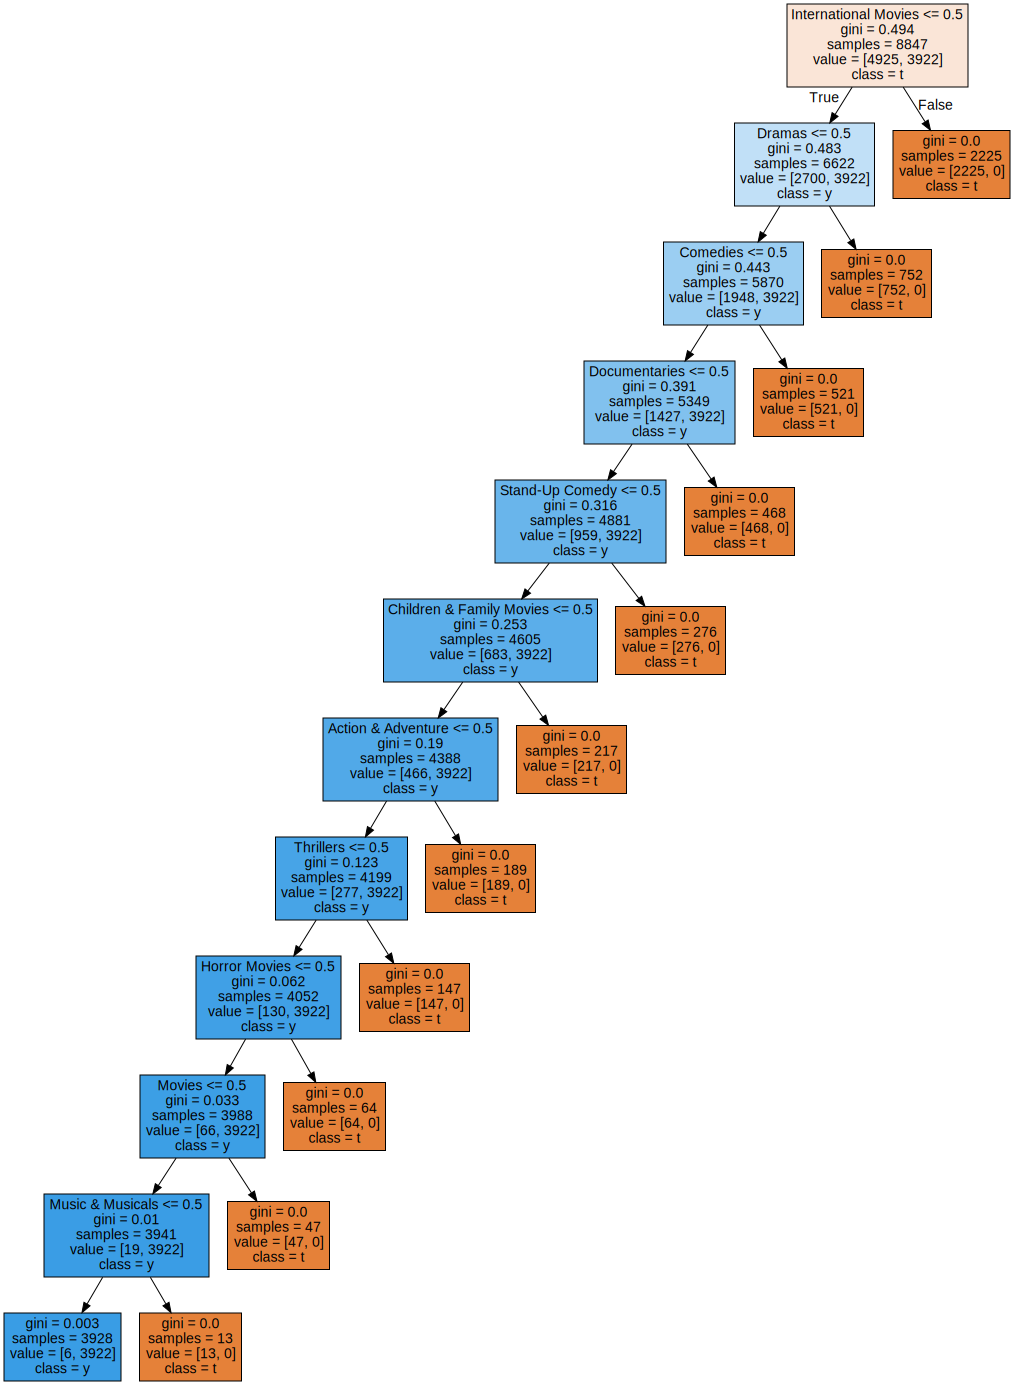

In [27]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns,  
                                class_names='type',
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

## Optimizing max_depth and min_samples_split using GridSearchCV

In [31]:
params = {'max_depth': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [32]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=11, random_state=42)

We can see that the best value for **max_depth** is 11 and the best value for **min_samples_split** is 2.

## Changing the train/test ratio

If the test set is relatively small, but it meaningfully represents the population you want to generalize on, then it is OK. Obviously, the greater size of the test set, the greater chance of having representative sample in test set.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=1)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


If the training set is relatively small, we can say in most of the time that the model won't learn very well.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9995479204339964


## Changing max_depth

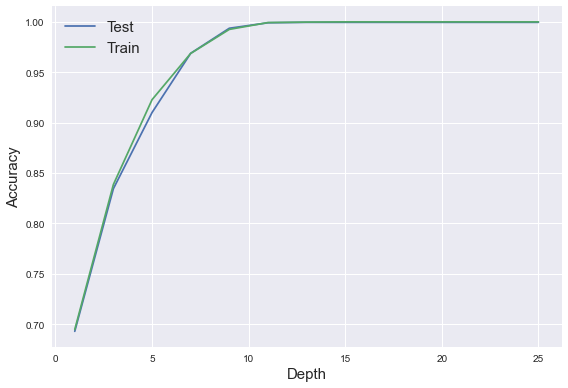

In [28]:
depths = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
test_accs = []
train_accs = []
for depth in depths:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    test_accs.append(metrics.accuracy_score(y_test, y_pred))
    train_accs.append(metrics.accuracy_score(y_train, y_pred_train))
    
plt.plot(depths, test_accs, label='Test')
plt.plot(depths, train_accs, label='Train')
plt.xlabel('Depth', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

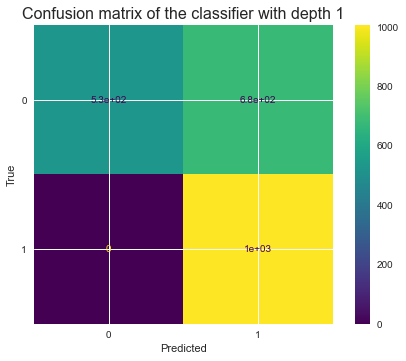

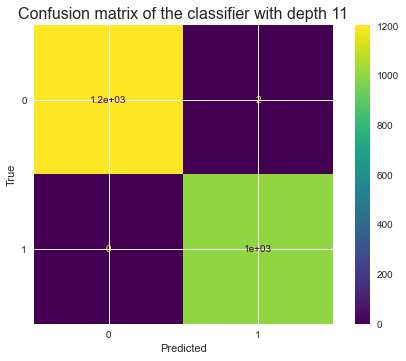

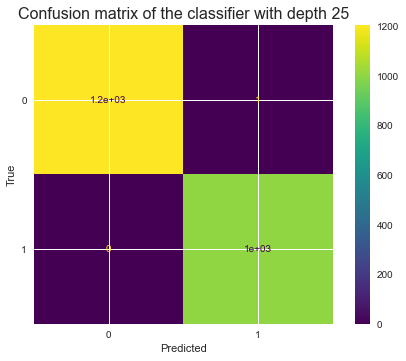

In [29]:
depths = [1, 11, 25]
for depth in depths:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    plot_confusion_matrix(clf, X_test, y_test)
    labels = ['business', 'health']
    plt.title(f'Confusion matrix of the classifier with depth {depth}', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Predicting using our second model 

In [30]:
X_2 = copy.deepcopy(df_2.drop(columns=['type', 'title', 'description', 'cast', 'listed_in']))
y_2 = copy.deepcopy(df_2['type'])
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=depth)
clf = clf.fit(X_train_2,y_train_2)
y_pred_2 = clf.predict(X_test_2)
print("Accuracy:", metrics.accuracy_score(y_test_2, y_pred_2))

Accuracy: 0.645117540687161


Here we can see the impact of extracting features from the set attribute(listed_in)!

***
# Phase Three: Predicting Using Ensembling Methods

## Hyperparameters
### n_estimators
The number of trees in the forest.(default: 100)
### criterion
The function to measure the quality of a split.({“gini”, “entropy”}, default=”gini”)
### max_depth
The maximum depth of the tree.
### min_samples_split
The minimum number of samples required to split an internal node.

In [31]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=11)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9945750452079566


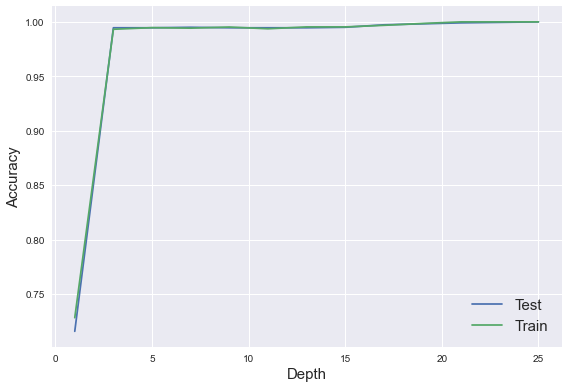

In [32]:
depths = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
test_accs = []
train_accs = []
for depth in depths:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    test_accs.append(metrics.accuracy_score(y_test, y_pred))
    train_accs.append(metrics.accuracy_score(y_train, y_pred_train))
    
plt.plot(depths, test_accs, label='Test')
plt.plot(depths, train_accs, label='Train')
plt.xlabel('Depth', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

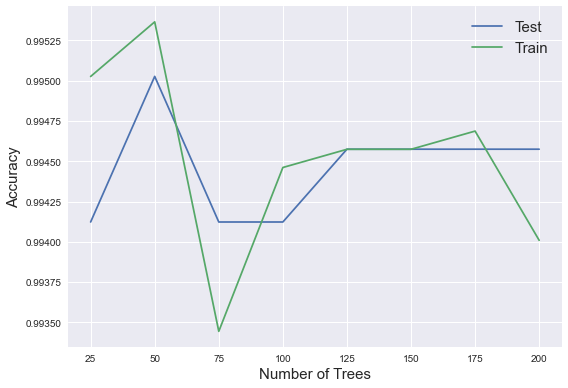

In [33]:
n_estimators = [25, 50, 75, 100, 125, 150, 175, 200]
test_accs = []
train_accs = []
for n_estimator in n_estimators:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    clf = RandomForestClassifier(n_estimators=n_estimator, criterion="entropy", max_depth=11)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    test_accs.append(metrics.accuracy_score(y_test, y_pred))
    train_accs.append(metrics.accuracy_score(y_train, y_pred_train))
    
plt.plot(n_estimators, test_accs, label='Test')
plt.plot(n_estimators, train_accs, label='Train')
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

Here as we increase the number of trees, the difference between train and test accuracy increases too.(Overfit)

## Comparison Random Forest results with Decision Tree results

The results are almost the same, but here because our decision tree model works very well, and also because it doesn't have an overfitting problem, it's not necessary to implement random forest. 

## Bias and Variance

### Bias
In statistics, the bias of an estimator is the difference between the estimator's expected value and the true value of the parameter being estimated. Model with high bias pays very little attention to the training data and oversimplifies the model.
### Variance
Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. 

### Bias Variance Tradeoff
To wrap things up, we can relate the Bias Variance decomposition to the commonly used terms overfitting and underfitting in the following informal way:
- **Overfitting** relates to having a **High Variance** model or estimator. To fight overfitting, we need to focus on reducing the Variance of the estimator, such as: increase regularization, obtain larger data set, decrease number of features, use a smaller model, etc.
- **Underfitting** relates to having a **High Bias** model or estimator. To fight underfitting, we need to focus on reducing the Bias in the estimator, such as: decrease regularization, use more features, use a larger model, etc.<br>

The first step in improving generalization error is to characterize which component in the decomposition has the highest contribution, and go after that component.

### Decision Tree and Random Forest in terms of Bias and Variance
Decision Tree has low bias but high variance, because it can easily change as small change in input variable.<br> In Random Forests the bias of the full model is equivalent to the bias of a single decision tree (which itself has high variance). By creating many of these trees, in effect a "forest", and then averaging them the variance of the final model can be greatly reduced over that of a single tree. So with using Random Forest, we can reduce variance and the bias doesn't change.

***
# Conclusion

Although this dataset and the features we used for implementing Decision Tree was perfect, we can see that usually, with ensembling methods, our accuracy is higher than simple Decision Tree since it stops overfitting. And we can also conclude that Preprocessing can have a leading role in Decision Tree algorithms.